In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import baseline_model

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [2]:
no_of_sensor = 16
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)

# Normalization
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))

# Create tf.dataset
dataset = tf.data.Dataset.from_tensor_slices((sensor_data_whole_array_norm,full_field_data_whole_array_norm))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)
print(dataset)


(429, 16)
(429, 128, 256, 1)
Check field data:  0.0 1.0
Check sens data:  0.008671743526994664 0.7910632602340727
<BatchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float64, name=None))>


## Autoencoder training (skip if autoencoder trained)

In [7]:
# tf.keras.backend.clear_session()
# flow_ae = baseline_model.AE()
# flow_ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999))
flow_ae.fit(dataset, epochs = 2, shuffle = True)

Epoch 1/2
54/54 [==============================] - 3s 51ms/step - loss: 1398.2745 - reconstruction_loss_ae: 1478.5698
Epoch 2/2
54/54 [==============================] - 3s 49ms/step - loss: 1382.5963 - reconstruction_loss_ae: 1340.8884


In [8]:
flow_ae.encoder.save_weights('encoder_ae.h5')
flow_ae.decoder.save_weights('decoder_ae.h5')

## Training

In [4]:
tf.keras.backend.clear_session()
flow_recon_ae = baseline_model.FLRNetAE(n_sensor = no_of_sensor)
flow_recon_ae.encoder.load_weights('encoder_ae.h5')
flow_recon_ae.decoder.load_weights('decoder_ae.h5')
# flow_recon_ae.sens_mapping.load_weights('mapping_8_ran_ae.h5')

flow_recon_ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.9, beta_2 = 0.999))
flow_recon_ae.fit(dataset, epochs = 1000, shuffle = True)

Epoch 1/1000
54/54 [==============================] - 9s 54ms/step - loss: 21775.7616 - reconstruction_loss_sens: 20095.4648
Epoch 2/1000
54/54 [==============================] - 2s 36ms/step - loss: 16882.0166 - reconstruction_loss_sens: 15901.2959
Epoch 3/1000
54/54 [==============================] - 2s 36ms/step - loss: 14820.1739 - reconstruction_loss_sens: 14647.0752
Epoch 4/1000
54/54 [==============================] - 2s 36ms/step - loss: 13856.7172 - reconstruction_loss_sens: 13466.7676
Epoch 5/1000
54/54 [==============================] - 2s 36ms/step - loss: 12369.4629 - reconstruction_loss_sens: 12166.5264
Epoch 6/1000
54/54 [==============================] - 2s 36ms/step - loss: 11128.8689 - reconstruction_loss_sens: 10935.3359
Epoch 7/1000
54/54 [==============================] - 2s 36ms/step - loss: 10370.5437 - reconstruction_loss_sens: 10070.4502
Epoch 8/1000
54/54 [==============================] - 2s 36ms/step - loss: 9915.6748 - reconstruction_loss_sens: 9459.7324
Ep

In [5]:
# Save model weight
filename = 'mapping_' + str(no_of_sensor) + '_ran_ae.h5'
flow_recon_ae.sens_mapping.save_weights(filename)

In [6]:
# Save model weight
# Prepare field data

Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 16)
(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493
Check sens data:  0.017918539916810732 0.7385736236309344


In [9]:
# Save model weight
# Reconstruction
    ## FLRNet
case_idx = 2
z_sens = flow_recon_ae.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
reconstruction_sens = flow_recon_ae.decoder(z_sens).numpy()



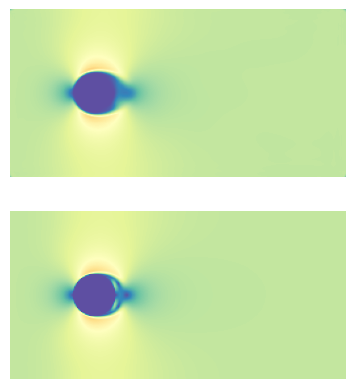

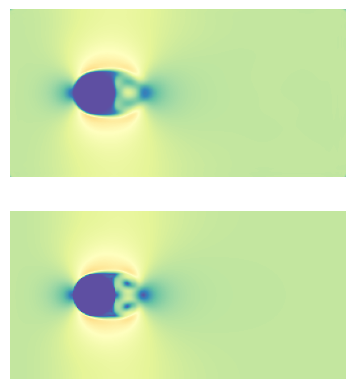

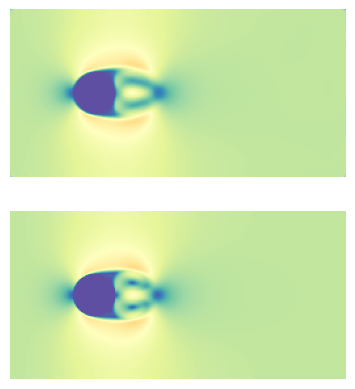

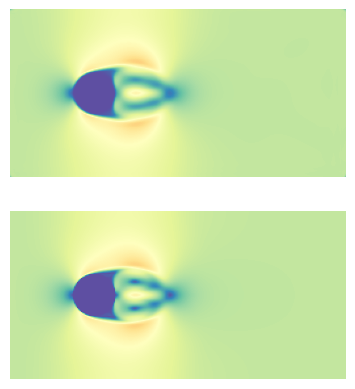

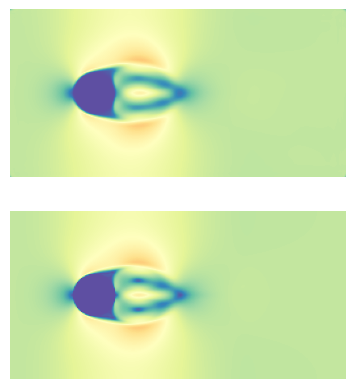

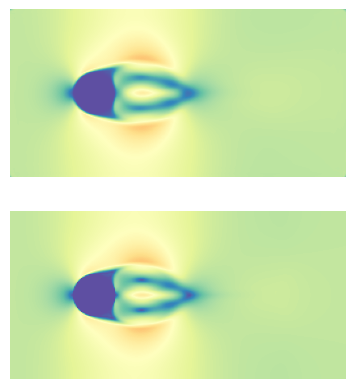

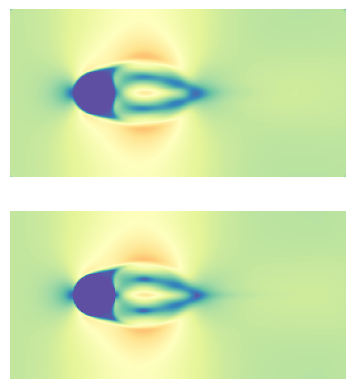

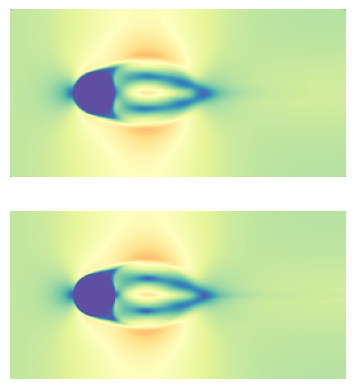

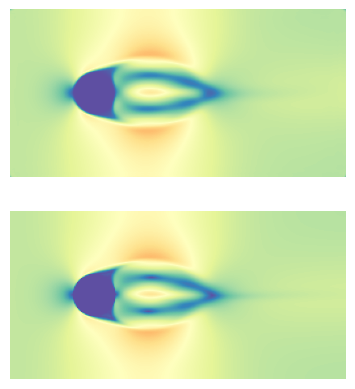

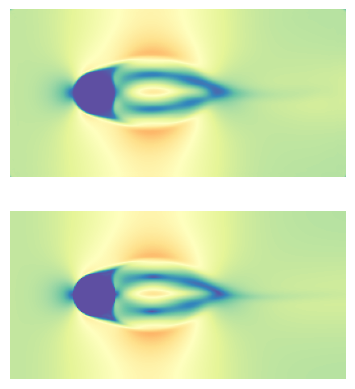

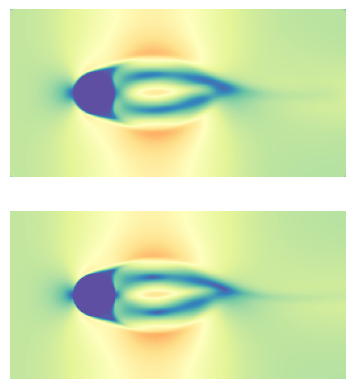

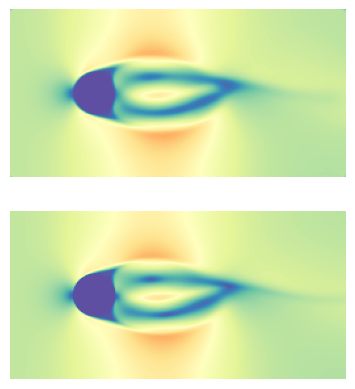

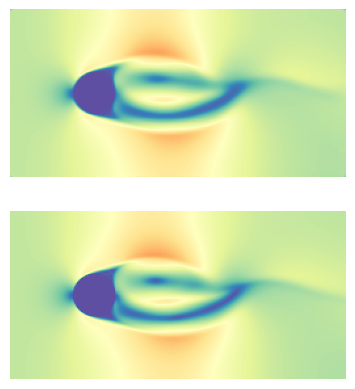

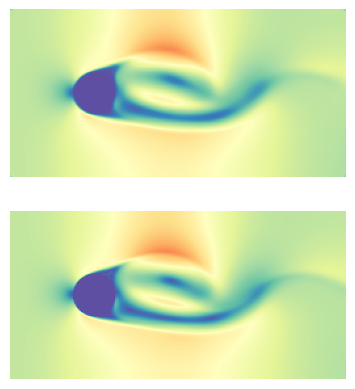

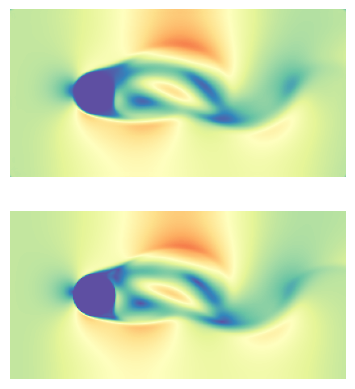

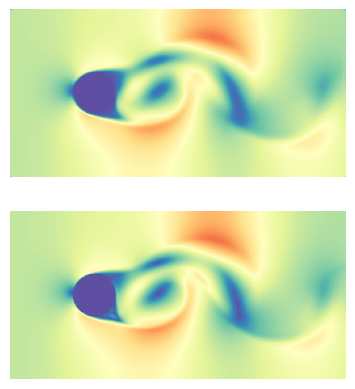

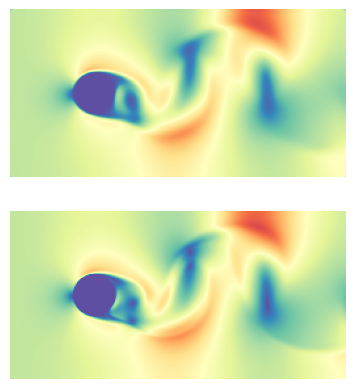

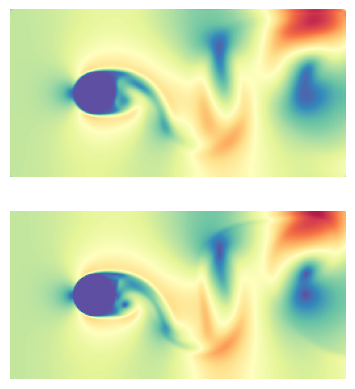

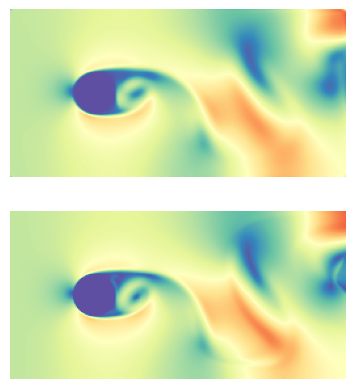

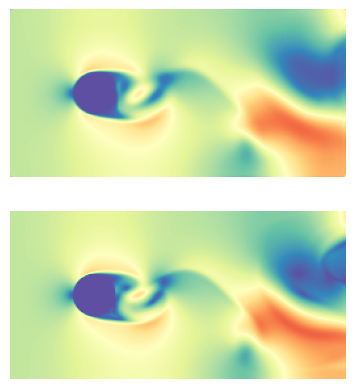

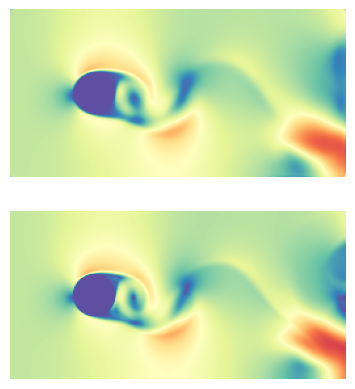

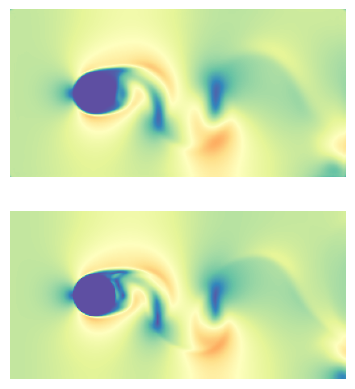

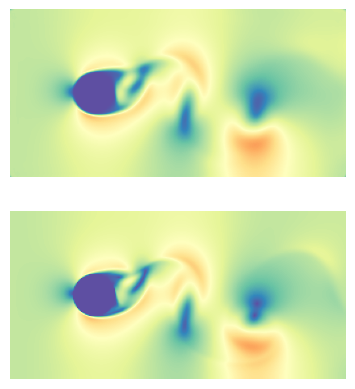

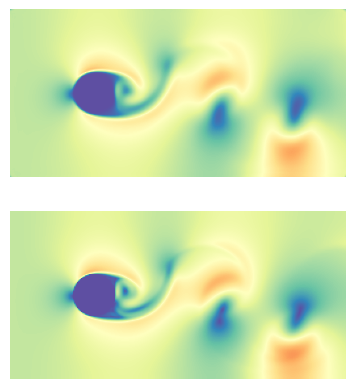

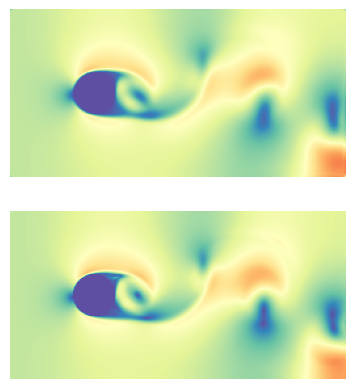

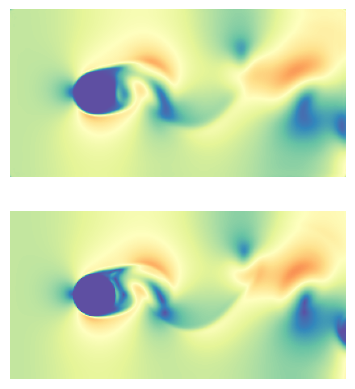

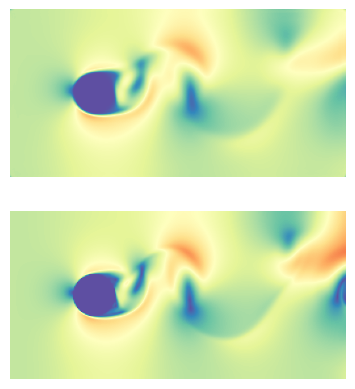

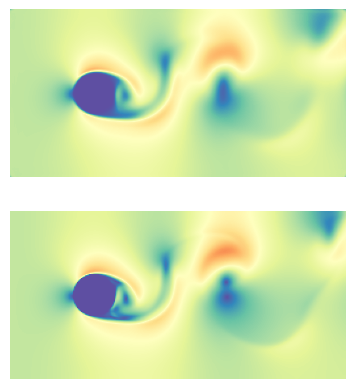

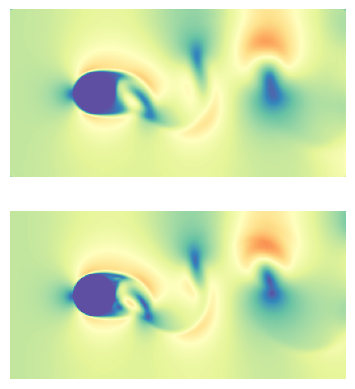

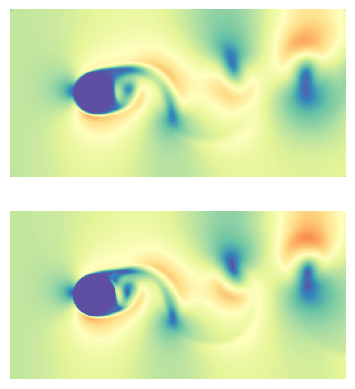

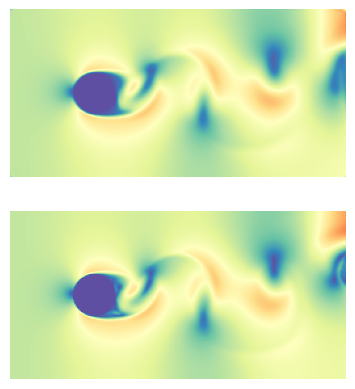

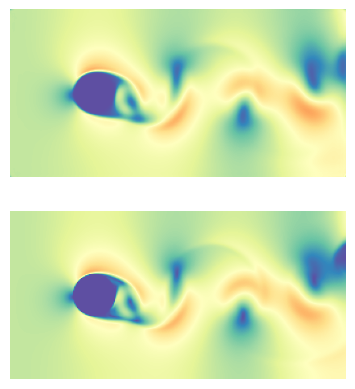

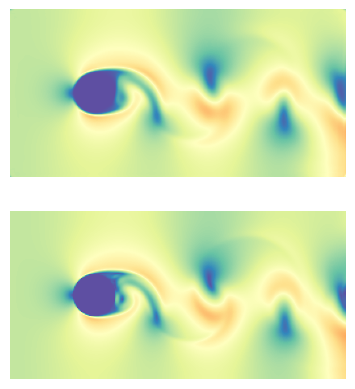

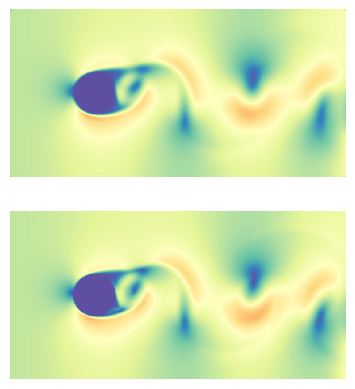

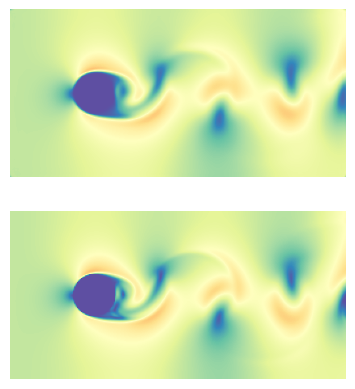

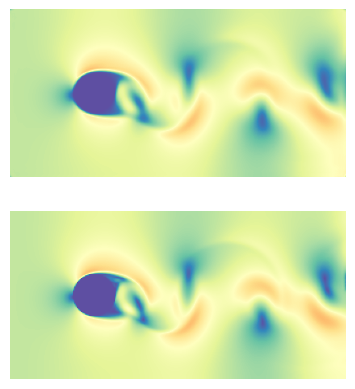

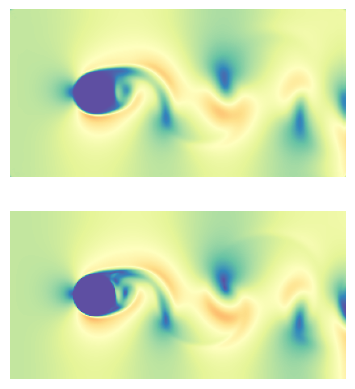

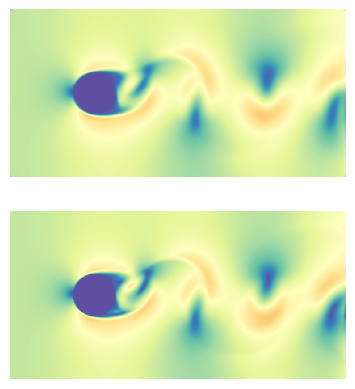

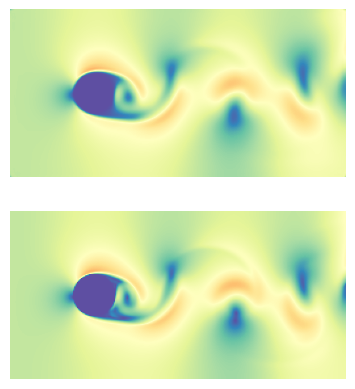

In [10]:
import matplotlib.pyplot as plt
for i in range(39):
    _, ax = plt.subplots(2,1)
    ax[0].imshow(reconstruction_sens[i,:,:,0], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(full_field_data_whole_test_norm[i+39*case_idx,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    plt.show()